### Problem 3
#### Milad Heidari
#### Student Number: 98101469

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer
from transformers import BertModel, DistilBertModel, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np
import random
import os

In [2]:
# set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# preparing the dataset

MAX_LINES = 10000

dataset = []
label_map = {}
prefix = 'poems/'
file_names = os.listdir(prefix)
for i, file in enumerate(file_names):
    num_beyts = 0
    poet_name = file.split('_')[0]
    label_map[i] = poet_name
    with open(prefix + file, 'r') as f:
        beyts = list(f)
        for line in beyts:
            beyt = line.strip()
            if len(beyt) == 0:
                continue
            dataset.append((beyt, i))
            num_beyts += 1
            if num_beyts >= MAX_LINES:
                break

In [4]:
print(f'dataset size: {len(dataset)}')
print()
print('label map:')
print(label_map)

dataset size: 100000

label map:
{0: 'amir', 1: 'attar', 2: 'jami', 3: 'bahar', 4: 'ghaani', 5: 'ferdousi', 6: 'bidel', 7: 'moulavi', 8: 'saadi', 9: 'sanaee'}


In [5]:
# train-test split of the dataset (25% of the data for testing)
train_data_orig, test_data_orig = train_test_split(dataset, test_size=0.2)
print(f'training set size: {len(train_data_orig)}')
print(f'test set size: {len(test_data_orig)}')

training set size: 80000
test set size: 20000


In [6]:
# initialize the tokenizer and dataset class

tokenizer = BertTokenizer.from_pretrained(
    'HooshvareLab/bert-fa-base-uncased'
)

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text, label = self.data[index]
        
        text = tokenizer(
            text,
            padding='max_length',
            max_length=25,
            truncation=True,
            return_tensors='pt',
        )
        
        return text, label

In [7]:
train_data = MyDataset(train_data_orig)
test_data = MyDataset(test_data_orig)
test_data_for_perplexity = MyDataset(test_data_orig[:1000])

### Feature Extraction

In [8]:
class BertClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.bert= BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.Sigmoid()
        )
        
    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        output = self.linear_relu_stack(pooled_output)
        return output

In [9]:
model = BertClassifier().to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# freeze parameters of the BERT module
for param in model.bert.parameters():
    param.requires_grad = False

In [11]:
# define hyperparameters
learning_rate = 1e-3
batch_size = 32
epochs = 4

In [12]:
# create loss function and dataloader
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        losses = []
        # forward prop
        y = y.to(device)
        mask = X['attention_mask'].to(device)
        input_id = X['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        loss = loss_fn(output, y)
        losses.append(loss.item())
        num_correct += (output.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_num % 100 == 0:
            print(f'batch: {batch_num}, loss: {np.mean(losses)}')
            losses = []
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            y = y.to(device)
            mask = X['attention_mask'].to(device)
            input_id = X['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            loss = loss_fn(output, y)
            num_correct += (output.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [14]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print()

epoch 1 ==================================================
batch: 0, loss: 2.3116447925567627
batch: 100, loss: 2.2903084754943848
batch: 200, loss: 2.278376817703247
batch: 300, loss: 2.2450242042541504
batch: 400, loss: 2.2146358489990234
batch: 500, loss: 2.2410593032836914
batch: 600, loss: 2.2591638565063477
batch: 700, loss: 2.12243914604187
batch: 800, loss: 2.2026891708374023
batch: 900, loss: 2.205671548843384
batch: 1000, loss: 2.0322110652923584
batch: 1100, loss: 2.2377426624298096
batch: 1200, loss: 2.1759121417999268
batch: 1300, loss: 2.1133975982666016
batch: 1400, loss: 2.1096227169036865
batch: 1500, loss: 2.163007974624634
batch: 1600, loss: 2.0782876014709473
batch: 1700, loss: 2.146310567855835
batch: 1800, loss: 2.122490167617798
batch: 1900, loss: 2.1481564044952393
batch: 2000, loss: 2.152341604232788
batch: 2100, loss: 2.089872121810913
batch: 2200, loss: 2.2090954780578613
batch: 2300, loss: 2.183229684829712
batch: 2400, loss: 2.062624931335449
train_loss: 2.

In [15]:
torch.save(model, 'feature_extractor.pt')
# model = torch.load('feature_extractor.pt')

In [16]:
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
estimated_labels = []
actual_labels = []

with torch.no_grad():
    for (X, y) in test_dataloader:
        mask = X['attention_mask'].to(device)
        input_id = X['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        actual_labels.append(y.item())
        estimated_labels.append(output.argmax(dim=1).item())

In [17]:
# classify arbitrary poem

poem = 'به لب رسیده مرا جان خودی به من برساند'
with torch.no_grad():
    token = tokenizer(
        poem,
        padding='max_length',
        max_length=25,
        truncation=True,
        return_tensors='pt',
    )
    
    mask = token['attention_mask'].to(device)
    input_id = token['input_ids'].squeeze(1).to(device)
    output = model(input_id, mask)
    print(output)
    predicted_label = output.argmax(dim=1).item()
    print(label_map[predicted_label])

tensor([[3.8672e-03, 5.3468e-01, 3.0875e-05, 1.8439e-02, 1.0571e-01, 5.9718e-08,
         8.8126e-01, 2.0849e-03, 9.9988e-01, 9.7074e-01]], device='cuda:0')
saadi


In [18]:
# classification report
print(classification_report(actual_labels, estimated_labels))

              precision    recall  f1-score   support

           0       0.36      0.45      0.40      1979
           1       0.29      0.26      0.28      2084
           2       0.34      0.31      0.32      1982
           3       0.30      0.10      0.15      2006
           4       0.27      0.09      0.13      2021
           5       0.44      0.58      0.50      1985
           6       0.45      0.66      0.53      1923
           7       0.26      0.31      0.28      1985
           8       0.27      0.47      0.35      2015
           9       0.21      0.13      0.16      2020

    accuracy                           0.33     20000
   macro avg       0.32      0.34      0.31     20000
weighted avg       0.32      0.33      0.31     20000



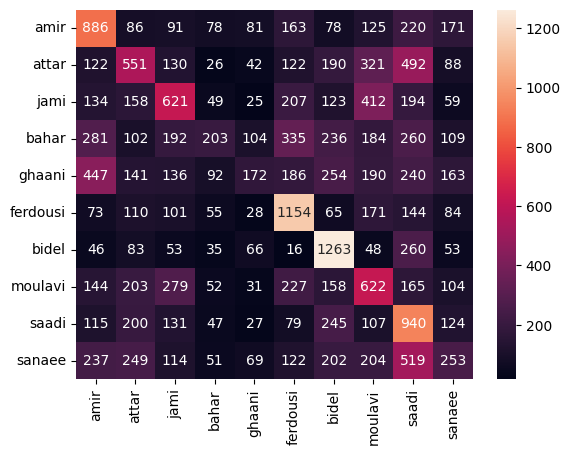

In [19]:
# confusion matrix
confmat = confusion_matrix(actual_labels, estimated_labels)
sns.heatmap(
    confmat,
    xticklabels=label_map.values(),
    yticklabels=label_map.values(),
    annot=True,
    fmt='d'
);

### Fine Tuning

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained(
    'HooshvareLab/distilbert-fa-zwnj-base'
)

In [9]:
model = DistilBertForSequenceClassification.from_pretrained(
    'HooshvareLab/distilbert-fa-zwnj-base',
    num_labels=10
).to(device)

Some weights of the model checkpoint at HooshvareLab/distilbert-fa-zwnj-base were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/distilbert-fa-zwnj-base and are newly initialized: ['classifier.weight', 'pre_cla

In [10]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [12]:
# calculating label probabilities before training
test_dataloader_for_perplexity = DataLoader(test_data_for_perplexity, batch_size=1)
probs_before_training = []

with torch.no_grad():
    for (X, y) in test_dataloader_for_perplexity:
        mask = X['attention_mask'].to(device)
        input_id = X['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        loss = output.loss
        logits = torch.nn.functional.softmax(output.logits, dim=1).squeeze()
        probs_before_training.append(logits[y.item()].item())

In [13]:
# define hyperparameters
learning_rate = 3e-5
batch_size = 4
epochs = 3

In [14]:
# create loss function and dataloader
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        losses = []
        # forward prop
        y = y.to(device)
        mask = X['attention_mask'].to(device)
        input_id = X['input_ids'].squeeze(1).to(device)
        output = model(
            input_ids=input_id,
            attention_mask=mask,
            labels=y)
        loss = output.loss
        logits = output.logits
        losses.append(loss.item())
        num_correct += (logits.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_num % 1000 == 0:
            print(f'batch: {batch_num}, loss: {np.mean(losses)}')
            losses = []
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            y = y.to(device)
            mask = X['attention_mask'].to(device)
            input_id = X['input_ids'].squeeze(1).to(device)
            output = model(
                input_ids=input_id,
                attention_mask=mask,
                labels=y)
            logits = output.logits
            num_correct += (logits.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [16]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print()

epoch 1 ==================================================
batch: 0, loss: 2.338038682937622
batch: 1000, loss: 2.1201162338256836
batch: 2000, loss: 2.1355464458465576
batch: 3000, loss: 1.2660924196243286
batch: 4000, loss: 1.9826786518096924
batch: 5000, loss: 0.38868314027786255
batch: 6000, loss: 1.4007742404937744
batch: 7000, loss: 2.271834373474121
batch: 8000, loss: 1.3110771179199219
batch: 9000, loss: 1.426571011543274
batch: 10000, loss: 1.8602544069290161
batch: 11000, loss: 1.251244306564331
batch: 12000, loss: 1.5744707584381104
batch: 13000, loss: 0.4928745627403259
batch: 14000, loss: 0.2475733906030655
batch: 15000, loss: 1.0818895101547241
batch: 16000, loss: 0.9768416881561279
batch: 17000, loss: 1.9667469263076782
batch: 18000, loss: 1.143692135810852
batch: 19000, loss: 1.3623651266098022
train_loss: 1.407374620437622
Train Accuracy: 51.43%
Test Accuracy: 60.7%

epoch 2 ==================================================
batch: 0, loss: 0.49606114625930786
batch: 1

In [21]:
# torch.save(model, 'fine_tuned.pt')
model = torch.load('fine_tuned.pt')

In [24]:
# calculating label probabilities after training
test_dataloader_for_perplexity = DataLoader(test_data_for_perplexity, batch_size=1)
probs_after_training = []

with torch.no_grad():
    for (X, y) in test_dataloader_for_perplexity:
        mask = X['attention_mask'].to(device)
        input_id = X['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        loss = output.loss
        logits = torch.nn.functional.softmax(output.logits, dim=1).squeeze()
        probs_after_training.append(logits[y.item()].item())

In [26]:
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
estimated_labels = []
actual_labels = []

with torch.no_grad():
    for (X, y) in test_dataloader:
        mask = X['attention_mask'].to(device)
        input_id = X['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        loss = output.loss
        logits = output.logits
        actual_labels.append(y.item())
        estimated_labels.append(logits.argmax(dim=1).item())

In [30]:
# classify arbitrary poem

poem = 'به لب رسیده مرا جان خودی به من برساند'
with torch.no_grad():
    token = tokenizer(
        poem,
        padding='max_length',
        max_length=25,
        truncation=True,
        return_tensors='pt',
    )
    
    mask = token['attention_mask'].to(device)
    input_id = token['input_ids'].squeeze(1).to(device)
    output = model(input_id, mask)
    loss = output.loss
    logits = output.logits
    predicted_label = logits.argmax(dim=1).item()
    print(label_map[predicted_label])

attar


In [28]:
# classification report
print(classification_report(actual_labels, estimated_labels))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1999
           1       0.63      0.60      0.61      1971
           2       0.72      0.69      0.71      2019
           3       0.60      0.41      0.48      1995
           4       0.58      0.48      0.52      2026
           5       0.82      0.94      0.88      1904
           6       0.86      0.86      0.86      2059
           7       0.67      0.68      0.68      1971
           8       0.61      0.68      0.64      2033
           9       0.47      0.62      0.53      2023

    accuracy                           0.66     20000
   macro avg       0.66      0.66      0.66     20000
weighted avg       0.66      0.66      0.66     20000



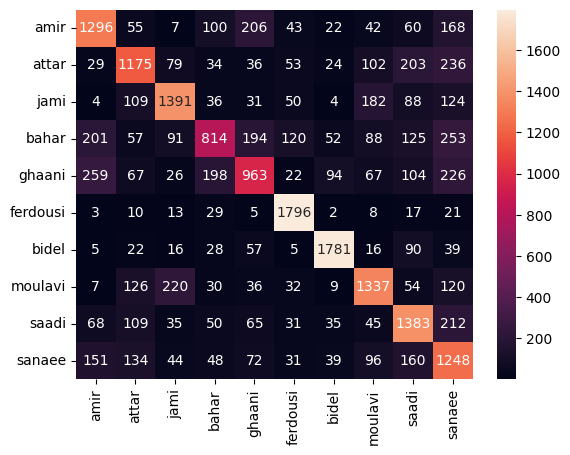

In [29]:
# confusion matrix
confmat = confusion_matrix(actual_labels, estimated_labels)
sns.heatmap(
    confmat,
    xticklabels=label_map.values(),
    yticklabels=label_map.values(),
    annot=True,
    fmt='d'
);

### Perplexity

In [47]:
# before training
perplexity_before_training = 1 / np.prod(np.array(probs_before_training) ** (1 / len(probs_before_training)))
# after training
perplexity_after_training = 1 / np.prod(np.array(probs_after_training) ** (1 / len(probs_after_training)))

In [48]:
print(f'Perplexity before training: {np.round(perplexity_before_training, 3)}')
print(f'Perplexity after training: {np.round(perplexity_after_training, 3)}')

Perplexity before training: 10.208
Perplexity after training: 2.77


As we can see, the `perplexity` is decreased after training, indicating the better generalization.